In [1]:
# import sys
# import os

# sys.path.append(os.path.abspath("../code"))

In [ ]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

from utils import *
from generate_data import * 

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import copy

from network import *

from torch_functions import *

from plot_data import *
from data_loading import *

import json

from ellipsoid_predictor import *
from hyper_rectangles import *


In [ ]:
seed_everything(44)

config_name = "scm1d001"

config_path = "../parameters/" + config_name + ".json"
with open(config_path, 'r') as file : 
    parameters = json.load(file)


prop_train = parameters["prop_train"]
prop_calibration = parameters["prop_calibration"]

# Chemin d'entrée et de sortie
load_path = "../data/processed_data/" + parameters["load_name"] + ".npz"

# Exemple d'utilisation du loader
X, Y = load_data(load_path)




normalize = parameters["normalize"]
splits = [parameters["prop_train"], parameters["prop_stop"], parameters["prop_calibration"], parameters["prop_test"]]

subsets = split_and_preprocess(X, Y, splits=splits, normalize=normalize)

x_train, y_train, x_calibration, y_calibration, x_test, y_test, x_stop, y_stop = subsets["X_train"], subsets["Y_train"], subsets["X_calibration"], subsets["Y_calibration"], subsets["X_test"], subsets["Y_test"], subsets["X_stop"], subsets["Y_stop"]

print("X_train shape:", x_train.shape, "Y_train shape:", y_train.shape)
print("X_cal shape:", x_calibration.shape, "Y_cal shape:", y_calibration.shape)
print("X_test shape:", x_test.shape, "Y_test shape:", y_test.shape)
print("X_stop shape:", x_stop.shape, "Y_stop shape:", y_stop.shape)

d = x_train.shape[1]
k = y_train.shape[1]

n_train = x_train.shape[0]
n_test = x_test.shape[0]
n_calibration = x_calibration.shape[0]
n_stop = x_stop.shape[0]

hidden_dim = parameters["hidden_dim"]
hidden_dim_matrix = parameters["hidden_dim_matrix"]
n_hidden_layers = parameters["n_hidden_layers"]
n_hidden_layers_matrix = parameters["n_hidden_layers_matrix"]

num_epochs_warm_start = parameters["num_epochs_warm_start"]
warm_start_epochs_mat = parameters["warm_start_epochs_mat"]
num_epochs_our_loss = parameters["num_epochs_our_loss"]

lr_warm_start = parameters["lr_warm_start"]
lr_model = parameters["lr_model"]
lr_matrix = parameters["lr_matrix"]
lr_q = parameters["lr_q"]

batch_size_warm_start = parameters["batch_size_warm_start"]
batch_size_our_loss = parameters["batch_size_our_loss"]

n_neighbors = parameters["n_neighbors"]
use_lr_scheduler = parameters["use_lr_scheduler"]
keep_best = parameters["keep_best"]

num_epochs_rectangles = parameters["num_epochs_rectangles"]
lr_rectangles = parameters["lr_rectangles"]
batch_size_rectangles = parameters["batch_size_rectangles"]

loss_strategy = parameters["loss_strategy"]
use_epsilon = parameters["use_epsilon"]

alpha = parameters["alpha"]
print(alpha)

X_train shape: (6862, 280) Y_train shape: (6862, 16)
X_cal shape: (980, 280) Y_cal shape: (980, 16)
X_test shape: (981, 280) Y_test shape: (981, 16)
X_stop shape: (980, 280) Y_stop shape: (980, 16)
0.01


Type de y_train : <class 'numpy.ndarray'>
Shape de y_train : (6862, 16)
Aperçu des 10 premières valeurs : [[ 1.67418578  1.99497097  1.68446368  2.35844488  1.00621052  0.07534535
   0.23035256  0.32557657  1.84252268  1.75022162  2.26139627  2.58088247
   0.8196557   1.5836802  -0.25360621  2.03310375]
 [-1.3041214  -0.76807531 -1.41811855 -0.9696755  -0.81265408 -0.68001258
  -0.77144968 -0.58200909 -1.22328725 -0.70552998 -1.50574701 -1.04874761
  -1.30791335 -0.93390994 -1.37811376 -0.90905815]
 [ 1.78236288  2.19689385  1.72746557  1.61591774 -0.2239158   0.2408278
  -0.01129136  0.50065121  0.34948301  0.69918325  0.41012933  0.8196557
   0.47240654  0.94645872  0.81440074  1.22064035]
 [-0.13844354 -0.26138737 -0.69590794 -0.80916817  0.15619937 -0.70875186
  -1.07297288 -1.38462826  0.53943086  0.52930109 -0.09549215 -0.25101592
   0.63792343  1.46786042 -0.93779777 -1.28383641]
 [-0.24454752 -0.45842568 -0.27830169 -0.45285848  1.22594275  1.83797516
   1.16676025  0.70714    

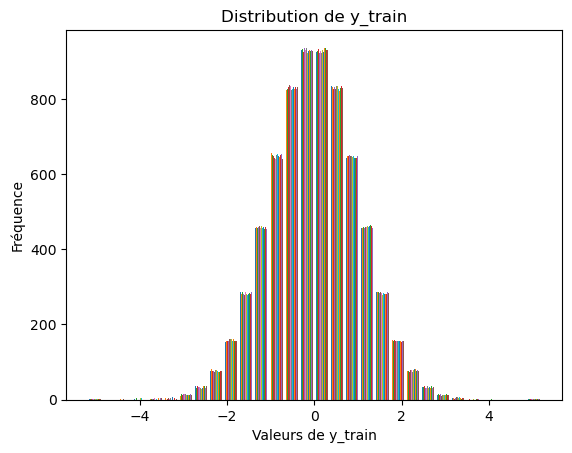

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Infos générales
print(f"Type de y_train : {type(y_train)}")
print(f"Shape de y_train : {y_train.shape}")

# Aperçu des premières valeurs
print("Aperçu des 10 premières valeurs :", y_train[:10])

# Statistiques générales
print(f"Min: {np.min(y_train)}, Max: {np.max(y_train)}")
print(f"Moyenne: {np.mean(y_train)}, Médiane: {np.median(y_train)}, Écart-type: {np.std(y_train)}")

# Vérification si y_train est catégoriel ou continu
unique, counts = np.unique(y_train, return_counts=True)
if len(unique) < 20:  # Suppose que <20 valeurs uniques signifie classification
    print("\nRépartition des classes :")
    for u, c in zip(unique, counts):
        print(f"Classe {u}: {c} occurrences")
    
    # Affichage sous forme de barres pour une classification
    plt.bar(unique, counts)
    plt.xlabel("Classes")
    plt.ylabel("Nombre d’occurrences")
    plt.title("Répartition des classes dans y_train")
else:
    # Affichage sous forme d'histogramme pour une régression
    plt.hist(y_train, bins=30)
    plt.xlabel("Valeurs de y_train")
    plt.ylabel("Fréquence")
    plt.title("Distribution de y_train")

plt.show()


In [5]:
x_train_tensor = torch.tensor(x_train, dtype=torch.float64)
y_train_tensor = torch.tensor(y_train, dtype=torch.float64)
x_stop_tensor = torch.tensor(x_stop, dtype=torch.float64)
y_stop_tensor = torch.tensor(y_stop, dtype=torch.float64)
x_calibration_tensor = torch.tensor(x_calibration, dtype=torch.float64)
y_calibration_tensor = torch.tensor(y_calibration, dtype=torch.float64)
x_test_tensor = torch.tensor(x_test, dtype=torch.float64)
y_test_tensor = torch.tensor(y_test, dtype=torch.float64)

matrix_model = MatrixPredictor(d, k, k, hidden_dim=hidden_dim_matrix).double()
model = Network(d, k, hidden_dim=hidden_dim, n_hidden_layers=n_hidden_layers).double()
q = torch.tensor(2.0, dtype=torch.float64, requires_grad=True)

trainloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train_tensor, y_train_tensor), batch_size= batch_size_warm_start, shuffle=True)
stoploader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_stop_tensor, y_stop_tensor), batch_size= batch_size_warm_start, shuffle=True)
train_losses, stop_losses = model.fit_and_plot(trainloader, stoploader, epochs=num_epochs_warm_start, lr=lr_warm_start, keep_best=keep_best)

warm_start_model = copy.deepcopy(model)

Network with  1 hidden layers and a hidden dimension of  256


In [6]:
lr_warm_start

1e-05

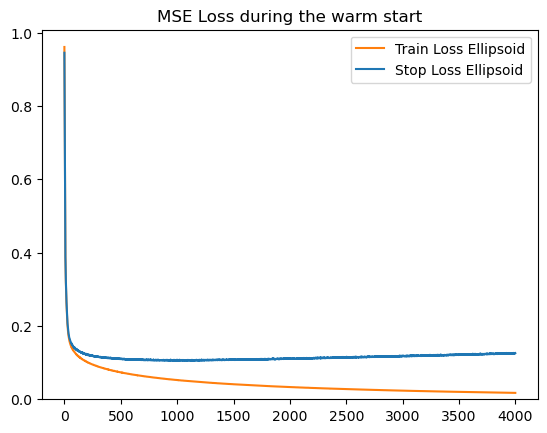

In [7]:
# Define colors for each model
half_ellipsoid_color = 'tab:blue'
ellipsoid_color = 'tab:orange'

plt.plot(train_losses, linestyle='-', color=ellipsoid_color, label='Train Loss Ellipsoid')
plt.plot(stop_losses, linestyle='-', color=half_ellipsoid_color, label='Stop Loss Ellipsoid')

plt.title("MSE Loss during the warm start")
plt.ylim(bottom=0)
plt.legend()
plt.show()
plt.close()

In [8]:
print(lr_matrix)
print(np.argmin(stop_losses))
print(np.min(stop_losses))

0.0001
975
0.10546258570345919


In [9]:
# 0.0001
# 1796
# 0.150977564489648

In [10]:
print(loss_strategy)
q = torch.tensor(2.0, dtype=torch.float64, requires_grad=True)

log_volume


In [11]:
# batch_size_our_loss = 200
# lr_matrix = 0.0001
# lr_q = 0.0001
# lr_matrix = 0.00005
# lr_model = 0.0005

# lr_q = 0.01
# lr_model = 0.001
warm_start_epochs_mat = 5000
# num_epochs_our_loss = 3000
# loss_strategy = "log_volume"
# use_epsilon = False
# use_lr_scheduler = True
# loss_strategy = "exact_volume"

model = copy.deepcopy(warm_start_model).double()
matrix_model = MatrixPredictor(d, k, k, hidden_dim=hidden_dim_matrix).double()

trainloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train_tensor, y_train_tensor), batch_size= batch_size_our_loss, shuffle=True)
stoploader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_stop_tensor, y_stop_tensor), batch_size= batch_size_our_loss, shuffle=True)
calibrationloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_calibration_tensor, y_calibration_tensor), batch_size= batch_size_our_loss, shuffle=True)
testloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test_tensor, y_test_tensor), batch_size= batch_size_our_loss, shuffle=True)

ellipsoid_predictor = EllipsoidPredictor(model, matrix_model, q)

ellipsoid_predictor.fit(trainloader, 
                        stoploader, 
                        alpha,
                        num_epochs = num_epochs_our_loss,
                        num_epochs_mat_only = warm_start_epochs_mat,
                        lr_model =lr_model,
                        lr_q = lr_q,
                        lr_matrix_model = lr_matrix,
                        use_lr_scheduler = use_lr_scheduler,
                        verbose = 2,
                        stop_on_best = keep_best,
                        loss_strategy = loss_strategy,
                        use_epsilon = use_epsilon,
                        )

New best stop loss: 80.08847575000344
Epoch 0: Loss = 70.61419862062785 - Stop Loss = 80.08847575000344 - Best Stop Loss = 80.08847575000344
Epoch 1: Loss = 68.40002725405733 - Stop Loss = 82.62485074681655 - Best Stop Loss = 80.08847575000344
Epoch 2: Loss = 73.03128714892821 - Stop Loss = 84.54827519535647 - Best Stop Loss = 80.08847575000344
Epoch 3: Loss = 69.50844829994867 - Stop Loss = 82.06791774737334 - Best Stop Loss = 80.08847575000344
New best stop loss: 79.74209574554109
Epoch 4: Loss = 68.09289390833598 - Stop Loss = 79.74209574554109 - Best Stop Loss = 79.74209574554109
Epoch 5: Loss = 72.7764463408325 - Stop Loss = 79.78123594869881 - Best Stop Loss = 79.74209574554109
Epoch 6: Loss = 67.76257760561275 - Stop Loss = 79.85425714238227 - Best Stop Loss = 79.74209574554109
Epoch 7: Loss = 67.55339366264755 - Stop Loss = 79.93945947884936 - Best Stop Loss = 79.74209574554109
Epoch 8: Loss = 67.47635524854682 - Stop Loss = 79.95016705901277 - Best Stop Loss = 79.7420957455410

KeyboardInterrupt: 

In [12]:
ellipsoid_predictor.load_best_model()

In [95]:
from covariances import *
from local_covariances import *

In [96]:
model_final_loss_calibration = ellipsoid_predictor.model.eval(calibrationloader)
warm_start_model_loss_calibration = warm_start_model.eval(calibrationloader)

if model_final_loss_calibration < warm_start_model_loss_calibration:
    covariance_predictor = CovariancePredictor(ellipsoid_predictor.model)
    local_covariance_predictor = LocalCovariancePredictor(ellipsoid_predictor.model, n_neighbors=n_neighbors)

    covariance_predictor.fit(trainloader)
    local_covariance_predictor.fit(trainloader)
    print('keeping the final model')
else:
    covariance_predictor = CovariancePredictor(warm_start_model)
    local_covariance_predictor = LocalCovariancePredictor(warm_start_model, n_neighbors=n_neighbors, dtype=torch.float64)
    covariance_predictor.fit(trainloader)
    local_covariance_predictor.fit(trainloader)
    print('keeping the warm started model')

keeping the warm started model


In [97]:
covariance_predictor.conformalize(calibrationloader, alpha = alpha)
local_covariance_predictor.conformalize(x_calibration=x_calibration_tensor, y_calibration=y_calibration_tensor, alpha = alpha)
ellipsoid_predictor.conformalize(calibrationloader, alpha = alpha)

8


In [99]:
print(ellipsoid_predictor.get_coverage(x_test=x_test_tensor, y_test=y_test_tensor))
print(covariance_predictor.get_coverage(x_test=x_test_tensor, y_test=y_test_tensor))
print(local_covariance_predictor.get_coverage(x_test=x_test_tensor, y_test=y_test_tensor))

print("")
print(ellipsoid_predictor.get_averaged_volume(x_test=x_test_tensor))
print(covariance_predictor.get_averaged_volume(x_test = x_test_tensor))
print(local_covariance_predictor.get_averaged_volume(x_test = x_test_tensor))


0.9877675771713257
0.9877675771713257
0.9877675771713257

6452142626.584271
5155731162.191559
5155732228.572149


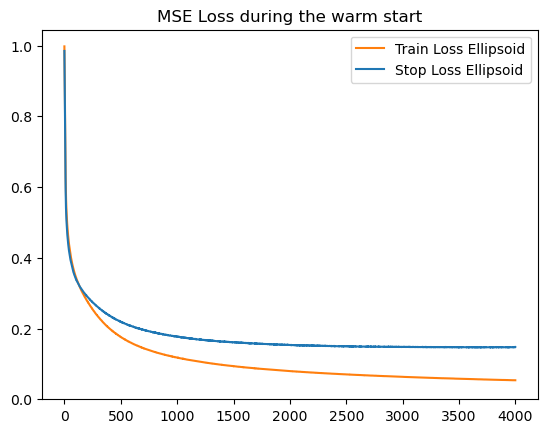

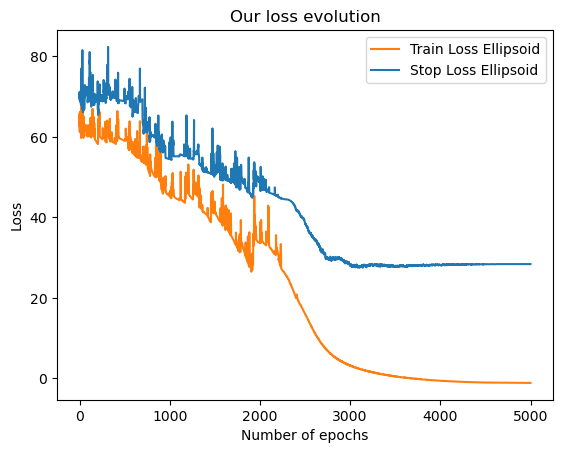

3139
27.489318930535585


In [ ]:
# Define colors for each model
half_ellipsoid_color = 'tab:blue'
ellipsoid_color = 'tab:orange'

plt.plot(train_losses, linestyle='-', color=ellipsoid_color, label='Train Loss Ellipsoid')
plt.plot(stop_losses, linestyle='-', color=half_ellipsoid_color, label='Stop Loss Ellipsoid')

plt.title("MSE Loss during the warm start")
plt.ylim(bottom=0)
plt.legend()
plt.show()
plt.close()

# Second plot: Loss evolution
plt.plot(ellipsoid_predictor.tab_train_loss, linestyle='-', color=ellipsoid_color, label='Train Loss Ellipsoid')
plt.plot(ellipsoid_predictor.tab_stop_loss, linestyle='-', color=half_ellipsoid_color, label='Stop Loss Ellipsoid')
# plt.plot(ellipsoid_predictor.tab_train_loss[1000:], linestyle='-', color=ellipsoid_color, label='Train Loss Ellipsoid')
# plt.plot(ellipsoid_predictor.tab_stop_loss[1000:], linestyle='-', color=half_ellipsoid_color, label='Stop Loss Ellipsoid')

plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.title('Our loss evolution')
plt.legend()
plt.show()
plt.close()
print(np.argmin(ellipsoid_predictor.tab_stop_loss))
print(np.min(ellipsoid_predictor.tab_stop_loss))


In [ ]:
hyper_rectangle_predictor = HyperRectanglePredictor(d, k, alpha, hidden_dim = hidden_dim, n_layers = n_hidden_layers)

Network with  1 hidden layers and a hidden dimension of  256
Network with  1 hidden layers and a hidden dimension of  256
Network with  1 hidden layers and a hidden dimension of  256
Network with  1 hidden layers and a hidden dimension of  256
Network with  1 hidden layers and a hidden dimension of  256
Network with  1 hidden layers and a hidden dimension of  256
Network with  1 hidden layers and a hidden dimension of  256
Network with  1 hidden layers and a hidden dimension of  256
Network with  1 hidden layers and a hidden dimension of  256
Network with  1 hidden layers and a hidden dimension of  256
Network with  1 hidden layers and a hidden dimension of  256
Network with  1 hidden layers and a hidden dimension of  256
Network with  1 hidden layers and a hidden dimension of  256
Network with  1 hidden layers and a hidden dimension of  256
Network with  1 hidden layers and a hidden dimension of  256
Network with  1 hidden layers and a hidden dimension of  256
Network with  1 hidden l

In [ ]:
n = 100
alpha = 0.1
p = np.ceil((n+1)*(1-alpha))
print(int(alpha * n) )
print(p)

10
91.0


In [ ]:
hyper_rectangle_predictor.fit(x_train, y_train, x_stop, y_stop,
                              num_epochs = num_epochs_rectangles, 
                              lr = lr_rectangles,
                              batch_size = batch_size_rectangles,
                              use_lr_scheduler = use_lr_scheduler,
                              keep_best = keep_best)

KeyboardInterrupt: 

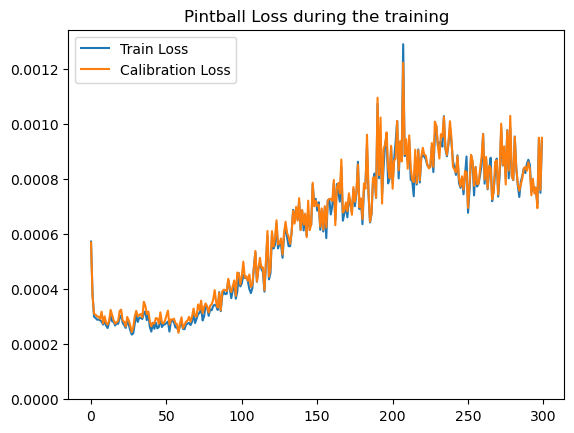

In [ ]:
plt.plot(hyper_rectangle_predictor.tab_loss, label='Train Loss')
plt.plot(hyper_rectangle_predictor.tab_loss_stop, label='Calibration Loss')
plt.title("Pintball Loss during the training")
plt.ylim(bottom=0)  
plt.legend()
plt.show()
plt.close()

In [ ]:
hyper_rectangle_predictor.conformalize(x_calibration, y_calibration)
volume_hyper_rectangle, coverage_hyper_rectangles = hyper_rectangle_predictor.calculate_volume_and_coverage(x_test, y_test)

print(volume_hyper_rectangle)

6.664752371261836e+25


In [ ]:
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
f_x_test = ellipsoid_predictor.model(x_test_tensor)
f_x_test_np = f_x_test.detach().numpy()
f_x_test_cov_np = ellipsoid_predictor.model(torch.tensor(x_test, dtype=torch.float32)).detach().numpy()

Lambdas_test = ellipsoid_predictor.get_Lambdas(x_test)
Lambdas_test_np = Lambdas_test.detach().numpy()

# Lambdas_test_cov = covariance_predictor.get_Lambdas(x_test)
Lambdas_test_cov = covariance_predictor._Lambda_cov.unsqueeze(0).expand(y_test.shape[0], y_test.shape[1], y_test.shape[1]).clone()
Lambdas_test_cov_np = Lambdas_test_cov.detach().numpy()

q_val = ellipsoid_predictor.q.item()

idx = np.random.choice(len(y_test), 10, replace=False)

for i in idx:
    fig, ax = plt.subplots(figsize=(6, 6))
    
    # print(ellipsoid_predictor.get_averaged_volume(x_test=x_test_tensor[i]))
    # print(covariance_predictor.get_averaged_volume(x_test = x_test_tensor[i]))
    # volume_hyper_rectangle, coverage_hyper_rectangles = hyper_rectangle_predictor.calculate_volume_and_coverage(x_test[i], y_test[i])
    # print(volume_hyper_rectangle)
    ax.scatter(y_test[i, 0], y_test[i, 1], label='Calibration set')
    ax = add_ellipse(ax,  f_x_test_np[i], Lambdas_test_np[i], q_val, ellipsoid_predictor.nu_conformal.item(), color = "red", label='Conformal Ellipse for q = {}'.format(q_val))
    ax = add_ellipse(ax,  f_x_test_cov_np[i], Lambdas_test_cov_np[i], 2, covariance_predictor.nu_covariance.item(), color = "green", label='Conformal Ellipse Cov')
    ax = add_hyper_rectangle(ax, hyper_rectangle_predictor, x_test[i])
    

    ax.grid(True)
    ax.legend( loc = "best")
    
    ax.set_xlabel('y_1')
    ax.set_ylabel('y_2')

    plt.show()
    plt.close()

RuntimeError: mat1 and mat2 must have the same dtype, but got Float and Double